# Imports and constants

In [142]:
# IMPORT STATEMENTS



import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from customScripts import utilities as util
from customScripts import features as feat
from customScripts import onset
import scipy.signal

import librosa

In [143]:
# PARAMETERS



#number of samples / second
sampling_rate = 100000 #96000

#length of frame in samples
frame_length = 2000 #2048

#number of samples used as offset for earch consecutive frame
hop_length = 1000 #1024

#number of mel frequency bins to use
bin_number = 40 #80

# size of the running window (in frames) for the threshold function / constants to add/mult. with threshold
threshold_window_size = 61
threshold_add_parameter = 35 # 35 / 300 for median, 200 for mean (small multiplier seems better)
threshold_multiply_parameter = 7 # 7 / 1 for median, 1 for mean 

#set the desired number of frames / second here
ground_thruth_conversion_const = 100 #2 # not used

# get train file paths
train_onsets_paths, train_beats_paths, train_bpm_paths = util.get_file_paths('music_data/train')
# get test file paths
test_onsets_paths, test_beats_paths, test_bpm_paths = util.get_file_paths('music_data/test')

# prediction_paths = ['predictions/Muppets-02-01-01.csv', 'predictions/Muppets-02-04-04.csv', 'predictions/Muppets-03-04-03.csv']
# file_lengths = [1547, 1548, 1539] #in seconds

# tested paths
tested_path_all = 'music_data/train/al_Media-103515(9.1-19.1)'
tested_path_onsets = 'music_data/train/ah_development_guitar_2684_TexasMusicForge_Dandelion_pt1'

# Single track onset / bpm / beat detection

In [178]:
############################### CHOOSE A PATH (e.g. train_bpm_paths[0]) #################

path_single = tested_path_onsets
path_single = tested_path_all
#path_single = train_onsets_paths[0]

#########################################################################################

In [179]:
# FEATURE EXTRACTION AND LOADING GROUND TRUTH



# load single audio
print(path_single)
audio_single = util.load_audio(path_single + '.flac', sampling_rate)

# compute single audio spectrogram
spectrogram_single = feat.compute_spectrogram(audio_single, frame_length, hop_length, bin_number)
spectrogram_single_T = spectrogram_single.transpose()

#print('frame number:',len(spectrogram_single_T))
#print('bin number:',len(spectrogram_single))
print(path_single + '.onsets')
# compute ground truth for single audio
gt_onsets_single = util.load_onsets_gt(path_single + '.onsets', '/n')
try:
    gt_beats_single = util.load_beats_gt(path_single + '.beats', '/n')
except:
    gt_beats_single = None
    print('beats ground truth doesnt exist for this file!')
try:
    gt_bpm_single = util.load_bpm_gt(path_single + '.bpm', '/n')
except:
    gt_bpm_single = None
    print('bpm ground truth doesnt exist for this file!')

music_data/train/al_Media-103515(9.1-19.1)
music_data/train/al_Media-103515(9.1-19.1).onsets


In [180]:
# ONSET DETECTION

odf_single = onset.compute_odf(spectrogram_single, bin_number)
peaks_single = onset.apply_threshold_median(odf_single, 19, 60, 1, True)
maxima_frame_indices_single = onset.pick_local_peaks(peaks_single)
onset_time_stamps_single = maxima_frame_indices_single / 100

"""
for i, p in enumerate(peaks_single):
    if p > 0:
        print(i/100, '   ', p)
"""


print(len(onset_time_stamps_single))
print(len(gt_onsets_single))
for i in range(len(gt_onsets_single)):
        i_p = int(round(onset_time_stamps_single[i]*100))
        i_gt = int(round(gt_onsets_single[i]*100))
        print('predicted: ', onset_time_stamps_single[i], ' ', odf_single[i_p], '   actual: ', gt_onsets_single[i], ' ', odf_single[i_gt],)
;

max value:  421.91000851560364
mean value:  36.94553546740891
median value:  21.483248501547475
41
60
predicted:  0.01   208.3339710194856    actual:  0.02   182.07671141765823
predicted:  0.3   167.27034493052386    actual:  0.3   167.27034493052386
predicted:  0.39   100.30706067066004    actual:  0.4   21.723837030276194
predicted:  0.76   199.91467468809776    actual:  0.67   59.83158071725954
predicted:  1.01   94.71208625535073    actual:  0.76   199.91467468809776
predicted:  1.15   176.15320002842455    actual:  1.02   83.43013587847929
predicted:  1.38   122.0771402137279    actual:  1.15   176.15320002842455
predicted:  1.49   360.3191200855761    actual:  1.16   85.11383384694804
predicted:  1.89   167.53392312070724    actual:  1.4   92.36328961396114
predicted:  2.26   204.57049629562368    actual:  1.44   48.581761570122865
predicted:  2.5   86.24387067056705    actual:  1.52   217.88539317948997
predicted:  2.63   118.3460908754872    actual:  1.8   40.2308410688057
pred

IndexError: index 41 is out of bounds for axis 0 with size 41

In [ ]:
# OUTPUT



path_prediction_single = 'predictions' + path_single.split('train')[1]
np.savetxt(path_prediction_single + '.onsets', onset_time_stamps_single, fmt='%1.2f', delimiter="/n")

# File loading and feature extraction

In [199]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])
def estimate_tempo(odf):
    """
    Determine dominant tempi by means of auto-correlation.

    Parameters
    ----------
    odf : numpy array
        Onset detection function.

    Returns
    -------
    tempo : float
        Detected tempo (in bpm).

    """
    min_bpm = 50
    max_bpm = 200
    #corr = np.correlate(odf, odf, mode='full')
    #auto_corr = corr[int(corr.size/2)+1:]
    odf = scipy.signal.medfilt(odf, 5)
    min_temp_length = int(60/max_bpm * 100)
    max_temp_length = int(60/min_bpm * 100)
    auto_corr = acf(odf, odf.size-10)[min_temp_length:max_temp_length]
    #auto_corr = acf(odf, odf.size-10)[0:]
    tempo_length = (min_temp_length + np.argmax(auto_corr)) / 100.0
    print (tempo_length)
    print(np.arange(0, tempo_length, odf.size))
    return auto_corr
    #print(auto_corr)
    # TODO: your changes here
    tempo = 60.0 / tempo_length
    return tempo

0.75
[0.]
160.0


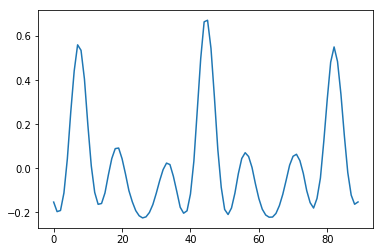

In [200]:
odf_single = np.array(odf_single)
#plt.plot(odf_single)
#tempo_bpm = estimate_tempo(odf_single)
acf = estimate_tempo(odf_single)
plt.plot(acf)
#print(tempo_bpm)
print (gt_bpm_single)

In [ ]:
# load onsets audio
train_onsets_audio = util.load_audios(train_onsets_audio_paths, sampling_rate)

In [ ]:
# compute onsets audio spectrogram

In [ ]:
# compute ground truth for onsets audio

In [ ]:
# load beats audio
train_beats_audio = util.load_audios(train_beats_audio_paths, sampling_rate)

In [ ]:
# compute beats audio spectrogram

In [ ]:
# compute ground truth for beats audio

In [ ]:
# load bpm audio
train_bpm_audio = util.load_audios(train_bpm_audio_paths, sampling_rate)

In [ ]:
# compute bpm audio spectrogram

In [ ]:
# compute ground truth for bpm audio
train_bpm_gt = util.load_ground_truths(train_bpm_gt_paths, '/n')
print(train_bpm_gt)

In [ ]:
#load ground truth, pad it with zeroes and adjust to frame number

#episode 1
"""
gt_1 = util.load_ground_truth(grount_truth_paths[0], '/n')
gt_1 = util.compute_0_padded_gt(gt_1, file_lengths[0])
gt_1 = util.adjust_gt_to_frames(gt_1, ground_thruth_conversion_const)
# append zeros so that lenght equals the frames list length
for i in range(len(spectrogram_1T) - len(gt_1)):
    gt_1.append(0)
print('ground truth size:',len(gt_1))
"""

In [ ]:
#concatenate training data
"""
gt_train = gt_1 + gt_2

spectrogram_train = np.concatenate((spectrogram_1T, spectrogram_2T), axis=0)

spectrogram_predict = spectrogram_3T

#spectrogram_train[3195] == spectrogram_2T[100]
"""
#for i,g in enumerate(gt_train):
#    if g == 1:
#        print(i)

# Classic onset detection method

# Classifier training and prediction for onsets

In [ ]:
# use a Multi-layer Perceptron classifier with default parameters
#clf = MLPClassifier()

In [ ]:
#clf.fit(spectrogram_train, gt_train)

In [ ]:
#prediction = clf.predict(spectrogram_predict)

In [ ]:
#np.savetxt(prediction_paths[2], prediction, delimiter="/n")

# Evaluation for onset detection

In [ ]:
"""
print('precision (micro average):',precision_score(gt_3, prediction, average='micro'))
print('precision (macro average):',precision_score(gt_3, prediction, average='macro'))
print('precision (weighted average):',precision_score(gt_3, prediction, average='weighted'))
"""

In [ ]:
"""
print('recall (micro average):',recall_score(gt_3, prediction, average='micro'))
print('recall (macro average):',recall_score(gt_3, prediction, average='macro'))
print('recall (weighted average):',recall_score(gt_3, prediction, average='weighted'))
"""

In [ ]:
"""
print('f1 (micro average):',f1_score(gt_3, prediction, average='micro'))
print('f1 (macro average):',f1_score(gt_3, prediction, average='macro'))
print('f1 (weighted average):',f1_score(gt_3, prediction, average='weighted'))
"""

In [ ]:
"""
# calculate false positive / true positive rate and area under curve
fpr, tpr, threshold = roc_curve(gt_3, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
"""